In [4]:
import os
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.datasets import EllipticBitcoinDataset
from torch_geometric.nn import GCNConv
from sklearn.metrics import classification_report

d:\DL Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
DEVICE = torch.device('cpu')
print('Using device:', DEVICE)

Using device: cpu


In [6]:
dataset = EllipticBitcoinDataset(root='./dataset')
data = dataset[0]
print(data)

Data(x=[203769, 165], edge_index=[2, 234355], y=[203769], train_mask=[203769], test_mask=[203769])


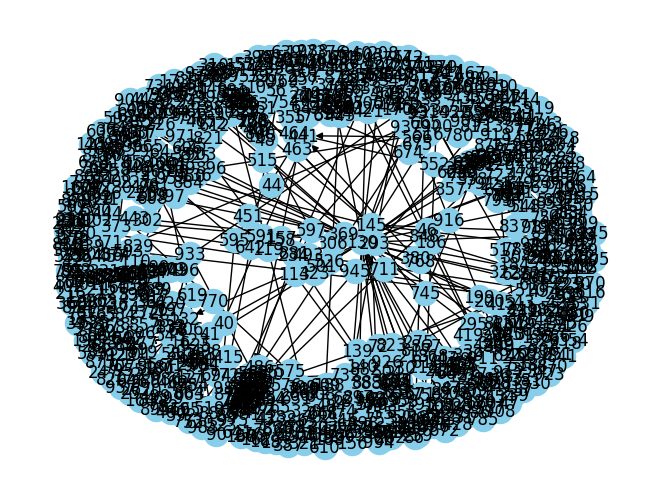

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert first 1000 nodes + edges to NetworkX graph
subgraph_nodes = range(1000)
subgraph = data.edge_index[:, (data.edge_index[0] < 1000) & (data.edge_index[1] < 1000)]
G = nx.DiGraph()
G.add_edges_from(subgraph.t().tolist())
nx.draw(G, with_labels=True, node_color='skyblue', node_size=300)
plt.show()

In [8]:
print(data.edge_index.dtype)  # Check the dtype of edge_index
print(data.y.unique())          # Check the dtype of labels

torch.int64
tensor([0, 1, 2])


In [9]:
data.edge_index = data.edge_index.to(torch.long)  
mask = data.y != -1
labels = data.y.clone()

In [10]:
from sklearn.model_selection import train_test_split
mask_idx = mask.nonzero(as_tuple=True)[0]
train_idx, test_idx = train_test_split(mask_idx.cpu(), test_size=0.3, stratify=labels[mask].cpu(), random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=labels[test_idx].cpu(), random_state=42)
train_idx = train_idx.to(DEVICE)
val_idx = val_idx.to(DEVICE)
test_idx = test_idx.to(DEVICE)

In [11]:
class GCNEncoder(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid_dim)
        self.conv2 = GCNConv(hid_dim, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        z = self.conv2(x, edge_index)
        return z

In [12]:
class AEClassifier(nn.Module):
    def __init__(self, encoder, out_dim):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.conv2.out_channels, out_dim)

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        out = self.classifier(z)
        # Reconstruction as regularizer
        # Use inner product reconstruction of adjacency (sparse)
        row, col = edge_index
        pos_scores = (z[row] * z[col]).sum(dim=1)
        recon_loss = -torch.log(torch.sigmoid(pos_scores) + 1e-8).mean()
        return out, recon_loss

In [21]:
# Hyperparameters
in_dim = data.x.size(1)
hid_dim = 128
out_dim = int(labels[mask].max().item() + 1)
lr = 0.01
weight_decay = 5e-4
epochs = 100
lambda_recon = 0.1

In [22]:
encoder = GCNEncoder(in_dim, hid_dim, 64).to(DEVICE)
model_base = AEClassifier(encoder, out_dim).to(DEVICE)
optimizer = torch.optim.Adam(model_base.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

def evaluate_model(model, data, test_idx, labels, name, metrics_store):
    model.eval()
    with torch.no_grad():
        logits, _ = model(data.x, data.edge_index)
        preds = logits.argmax(dim=1)[test_idx].cpu()
        y_true = labels[test_idx].cpu()

    precision = precision_score(y_true, preds, average='macro', zero_division=0)
    recall = recall_score(y_true, preds, average='macro', zero_division=0)
    f1 = f1_score(y_true, preds, average='macro', zero_division=0)
    acc = accuracy_score(y_true, preds)
    report = classification_report(y_true, preds, output_dict=True, zero_division=0)

    # Save metrics
    metrics_store[name] = {
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1": round(f1, 4),
        "accuracy": round(acc, 4),
        "per_class_report": report
    }

    print(f"✅ {name} Model Results:")
    print(f"  Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Accuracy: {acc:.4f}\n")
    print(f"  Per-Class Report:")
    for class_label, metrics in report.items():
        if class_label == "accuracy":
            continue
        print(f"    Class {class_label}: Precision: {metrics['precision']:.4f} | Recall: {metrics['recall']:.4f} | F1: {metrics['f1-score']:.4f}")
    return preds


In [24]:
# Training loop Normal
for epoch in range(1, epochs+1):
    model_base.train()
    optimizer.zero_grad()
    out, recon_loss = model_base(data.x, data.edge_index)
    ce_loss = F.cross_entropy(out[train_idx], labels[train_idx])
    loss = ce_loss + lambda_recon * recon_loss
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0 or epoch==1:
        model_base.eval()
        with torch.no_grad():
            pred = out.argmax(dim=1)
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")
            print("Validation Metrics:")
            print(classification_report(labels[val_idx].cpu(), pred[val_idx].cpu(), zero_division=0))


Epoch 001 | Loss: 1.0358
Validation Metrics:
              precision    recall  f1-score   support

           0       0.36      0.19      0.25      6303
           1       0.03      0.19      0.04       681
           2       0.81      0.76      0.79     23581

    accuracy                           0.63     30565
   macro avg       0.40      0.38      0.36     30565
weighted avg       0.70      0.63      0.66     30565

Epoch 005 | Loss: 0.5944
Validation Metrics:
              precision    recall  f1-score   support

           0       0.69      0.37      0.48      6303
           1       0.00      0.00      0.00       681
           2       0.83      0.96      0.89     23581

    accuracy                           0.82     30565
   macro avg       0.51      0.44      0.46     30565
weighted avg       0.78      0.82      0.79     30565

Epoch 010 | Loss: 0.5165
Validation Metrics:
              precision    recall  f1-score   support

           0       0.65      0.49      0.56     

In [34]:
# Test evaluation Normal
model_base.eval()
with torch.no_grad():
    out, _ = model_base(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    print("Test Metrics:")
    print(classification_report(data.y[test_idx].cpu(), pred[test_idx].cpu(), zero_division=0))

Test Metrics:
              precision    recall  f1-score   support

           0       0.69      0.06      0.12      6303
           1       0.00      0.00      0.00       682
           2       0.78      0.99      0.87     23581

    accuracy                           0.78     30566
   macro avg       0.49      0.35      0.33     30566
weighted avg       0.75      0.78      0.70     30566



In [35]:
metrics_data = {}

evaluate_model(model_base, data, test_idx, labels, "Base", metrics_data)

✅ Base Model Results:
  Precision: 0.4905 | Recall: 0.3526 | F1: 0.3308 | Accuracy: 0.7797

  Per-Class Report:
    Class 0: Precision: 0.6899 | Recall: 0.0643 | F1: 0.1176
    Class 1: Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
    Class 2: Precision: 0.7815 | Recall: 0.9935 | F1: 0.8748
    Class macro avg: Precision: 0.4905 | Recall: 0.3526 | F1: 0.3308
    Class weighted avg: Precision: 0.7452 | Recall: 0.7797 | F1: 0.6992


tensor([2, 2, 2,  ..., 2, 2, 2])

In [27]:
# Weighted Method
import torch
from torch.nn import CrossEntropyLoss

# Only training nodes
train_labels = labels[train_idx]

# Class counts and weights
class_counts = torch.bincount(train_labels)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum() * len(class_counts)
print("Class weights:", class_weights)

# Cross-entropy with weights
ce_loss_fn = CrossEntropyLoss(weight=class_weights)


Class weights: tensor([0.2854, 2.6383, 0.0763])


In [28]:
model_weighted = AEClassifier(encoder, out_dim).to(DEVICE)

# Training on weighted Data
for epoch in range(1, epochs+1):
    model_weighted.train()
    optimizer.zero_grad()
    out, recon_loss = model_weighted(data.x, data.edge_index)

    ce_loss = ce_loss_fn(out[train_idx], labels[train_idx])
    loss = ce_loss + lambda_recon * recon_loss
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0 or epoch==1:
        model_weighted.eval()
        with torch.no_grad():
            pred = out.argmax(dim=1)
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")
            print("Validation Metrics:")
            print(classification_report(labels[val_idx].cpu(), pred[val_idx].cpu(), zero_division=0))


Epoch 001 | Loss: 1.1305
Validation Metrics:
              precision    recall  f1-score   support

           0       0.26      0.06      0.10      6303
           1       0.06      0.34      0.10       681
           2       0.80      0.86      0.83     23581

    accuracy                           0.68     30565
   macro avg       0.38      0.42      0.34     30565
weighted avg       0.68      0.68      0.66     30565

Epoch 020 | Loss: 0.6228
Validation Metrics:
              precision    recall  f1-score   support

           0       0.53      0.74      0.62      6303
           1       0.11      0.81      0.19       681
           2       0.93      0.66      0.77     23581

    accuracy                           0.68     30565
   macro avg       0.52      0.74      0.53     30565
weighted avg       0.83      0.68      0.73     30565

Epoch 040 | Loss: 0.5591
Validation Metrics:
              precision    recall  f1-score   support

           0       0.59      0.73      0.65     

In [36]:
# Test evaluation for only weighted
model_weighted.eval()
with torch.no_grad():
    out, _ = model_weighted(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    print("Test Metrics:")
    print(classification_report(data.y[test_idx].cpu(), pred[test_idx].cpu(), zero_division=0))

Test Metrics:
              precision    recall  f1-score   support

           0       0.61      0.75      0.68      6303
           1       0.16      0.88      0.27       682
           2       0.93      0.75      0.83     23581

    accuracy                           0.76     30566
   macro avg       0.57      0.79      0.59     30566
weighted avg       0.85      0.76      0.79     30566



In [37]:
evaluate_model(model_weighted, data, test_idx, labels, "Weighted", metrics_data)

✅ Weighted Model Results:
  Precision: 0.5681 | Recall: 0.7945 | F1: 0.5924 | Accuracy: 0.7563

  Per-Class Report:
    Class 0: Precision: 0.6119 | Recall: 0.7547 | F1: 0.6759
    Class 1: Precision: 0.1575 | Recall: 0.8754 | F1: 0.2670
    Class 2: Precision: 0.9348 | Recall: 0.7533 | F1: 0.8343
    Class macro avg: Precision: 0.5681 | Recall: 0.7945 | F1: 0.5924
    Class weighted avg: Precision: 0.8509 | Recall: 0.7563 | F1: 0.7890


tensor([2, 2, 1,  ..., 0, 0, 2])

In [38]:
# Oversampling Class 1 Data

# Separate classes
idx_class0 = train_idx[train_labels == 0]
idx_class1 = train_idx[train_labels == 1]
idx_class2 = train_idx[train_labels == 2]

# Oversample minority (class 1) to match majority class
num_majority = max(len(idx_class0), len(idx_class2))
idx_class1_oversampled = idx_class1.repeat((num_majority // len(idx_class1) + 1))[:num_majority]

# Combine all
train_idx_balanced = torch.cat([idx_class0, idx_class1_oversampled, idx_class2])
train_idx_balanced = train_idx_balanced[torch.randperm(len(train_idx_balanced))]  # shuffle

In [39]:
model_weighted_oversampled = AEClassifier(encoder, out_dim).to(DEVICE)
# Training on weighted + oversampled data

for epoch in range(1, epochs+1):
    model_weighted_oversampled.train()
    optimizer.zero_grad()
    out, recon_loss = model_weighted_oversampled(data.x, data.edge_index)

    # Use oversampled indices
    ce_loss = ce_loss_fn(out[train_idx_balanced], labels[train_idx_balanced])
    loss = ce_loss + lambda_recon * recon_loss
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0 or epoch == 1:
        model_weighted_oversampled.eval()
        with torch.no_grad():
            pred = out.argmax(dim=1)
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")
            print("Validation Metrics:")
            print(classification_report(labels[val_idx].cpu(), pred[val_idx].cpu(), zero_division=0))


Epoch 001 | Loss: 1.0546
Validation Metrics:
              precision    recall  f1-score   support

           0       0.37      0.53      0.43      6303
           1       0.01      0.47      0.03       681
           2       0.26      0.00      0.00     23581

    accuracy                           0.12     30565
   macro avg       0.21      0.33      0.16     30565
weighted avg       0.28      0.12      0.09     30565

Epoch 005 | Loss: 0.4104
Validation Metrics:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6303
           1       0.02      1.00      0.04       681
           2       0.00      0.00      0.00     23581

    accuracy                           0.02     30565
   macro avg       0.01      0.33      0.01     30565
weighted avg       0.00      0.02      0.00     30565

Epoch 010 | Loss: 0.2604
Validation Metrics:
              precision    recall  f1-score   support

           0       0.64      0.33      0.43     

In [40]:
# Test evaluation using weighted + oversampling
model_weighted_oversampled.eval()
with torch.no_grad():
    out, _ = model_weighted_oversampled(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    print("Test Metrics:")
    print(classification_report(data.y[test_idx].cpu(), pred[test_idx].cpu(), zero_division=0))

Test Metrics:
              precision    recall  f1-score   support

           0       0.59      0.58      0.59      6303
           1       0.04      0.98      0.08       682
           2       0.94      0.37      0.53     23581

    accuracy                           0.43     30566
   macro avg       0.52      0.64      0.40     30566
weighted avg       0.85      0.43      0.53     30566



In [41]:
evaluate_model(model_weighted_oversampled, data, test_idx, labels, "Weighted + Oversampled", metrics_data)

✅ Weighted + Oversampled Model Results:
  Precision: 0.5243 | Recall: 0.6427 | F1: 0.4002 | Accuracy: 0.4262

  Per-Class Report:
    Class 0: Precision: 0.5913 | Recall: 0.5832 | F1: 0.5872
    Class 1: Precision: 0.0442 | Recall: 0.9765 | F1: 0.0845
    Class 2: Precision: 0.9375 | Recall: 0.3683 | F1: 0.5289
    Class macro avg: Precision: 0.5243 | Recall: 0.6427 | F1: 0.4002
    Class weighted avg: Precision: 0.8462 | Recall: 0.4262 | F1: 0.5310


tensor([2, 2, 1,  ..., 1, 1, 2])

In [42]:
# Labels and masks
labels = data.y.clone().to(DEVICE)     # [num_nodes]
# known nodes: classes 0 and 1
known_mask = (labels == 0) | (labels == 1)
known_idx = known_mask.nonzero(as_tuple=True)[0]
# unknown nodes: class 2
unknown_idx = (labels == 2).nonzero(as_tuple=True)[0]

In [43]:
train_idx, val_idx = train_test_split(
    known_idx.cpu().numpy(),
    test_size=0.2,
    stratify=labels[known_idx].cpu().numpy(),
    random_state=42
)
train_idx = torch.tensor(train_idx, dtype=torch.long, device=DEVICE)
val_idx = torch.tensor(val_idx, dtype=torch.long, device=DEVICE)
test_unknown_idx = unknown_idx.to(DEVICE)

print(f"Train known: {train_idx.size(0)}, Val known: {val_idx.size(0)}, Unknown test: {test_unknown_idx.size(0)}")

Train known: 37251, Val known: 9313, Unknown test: 157205


In [44]:
# compute class weights from training labels (only known classes)
train_labels = labels[train_idx]
class_counts = torch.bincount(train_labels)
# handle if some class missing in batch (rare)
if class_counts.numel() < 2:
    # ensure 2 classes exist
    tmp = torch.zeros(2, dtype=class_counts.dtype, device=class_counts.device)
    tmp[:class_counts.numel()] = class_counts
    class_counts = tmp
class_weights = 1.0 / class_counts.float()
class_weights = (class_weights / class_weights.sum()) * len(class_counts)
class_weights = class_weights.to(DEVICE)
print("Class counts:", class_counts.cpu().numpy(), "Class weights:", class_weights.cpu().numpy())

ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)

Class counts: [33615  3636] Class weights: [0.19521624 1.8047837 ]


In [45]:
class AEClassifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.conv2.out_channels, num_classes)

    def forward(self, x, edge_index):
        # Encode graph node embeddings
        z = self.encoder(x, edge_index)

        # Node classification
        out = self.classifier(z)

        # Reconstruction (inner product of embeddings)
        row, col = edge_index
        pos_scores = (z[row] * z[col]).sum(dim=1)
        recon_loss = -torch.log(torch.sigmoid(pos_scores) + 1e-8).mean()

        return out, recon_loss

In [47]:
num_classes = 2

encoder = GCNEncoder(in_dim, hid_dim, 64).to(DEVICE)
model_known_unknown = AEClassifier(encoder, num_classes).to(DEVICE)
optimizer = torch.optim.Adam(model_known_unknown.parameters(), lr=lr, weight_decay=weight_decay)

In [48]:
epochs = 100

for epoch in range(1, epochs + 1):
    model_known_unknown.train()
    optimizer.zero_grad()
    logits, z_all = model_known_unknown(data.x, data.edge_index)           # logits: [N, num_classes]
    # select only train nodes (labels 0 or 1)
    loss_ce = ce_loss_fn(logits[train_idx], labels[train_idx])
    rloss = torch.tensor(0.0, device=DEVICE)
    loss = loss_ce + lambda_recon * rloss
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0 or epoch == 1:
        model_known_unknown.eval()
        with torch.no_grad():
            logits_eval, _ = model_known_unknown(data.x, data.edge_index)
            preds_val = logits_eval[val_idx].argmax(dim=1).cpu()
            true_val = labels[val_idx].cpu()
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | CE: {loss_ce.item():.4f} | Recon: {rloss.item():.4f}")
            print("Val known metrics:")
            print(classification_report(true_val, preds_val, target_names=['licit(0)','illicit(1)'], zero_division=0))


Epoch 001 | Loss: 0.6727 | CE: 0.6727 | Recon: 0.0000
Val known metrics:
              precision    recall  f1-score   support

    licit(0)       0.94      0.96      0.95      8404
  illicit(1)       0.54      0.45      0.49       909

    accuracy                           0.91      9313
   macro avg       0.74      0.70      0.72      9313
weighted avg       0.90      0.91      0.91      9313

Epoch 005 | Loss: 0.4980 | CE: 0.4980 | Recon: 0.0000
Val known metrics:
              precision    recall  f1-score   support

    licit(0)       0.99      0.69      0.82      8404
  illicit(1)       0.25      0.94      0.39       909

    accuracy                           0.72      9313
   macro avg       0.62      0.81      0.60      9313
weighted avg       0.92      0.72      0.77      9313

Epoch 010 | Loss: 0.4204 | CE: 0.4204 | Recon: 0.0000
Val known metrics:
              precision    recall  f1-score   support

    licit(0)       0.99      0.75      0.85      8404
  illicit(1)      

In [50]:
evaluate_model(model_known_unknown, data, train_idx, labels, "Known-Unknown", metrics_data)

✅ Known-Unknown Model Results:
  Precision: 0.7861 | Recall: 0.9466 | F1: 0.8404 | Accuracy: 0.9273

  Per-Class Report:
    Class 0: Precision: 0.9966 | Recall: 0.9226 | F1: 0.9582
    Class 1: Precision: 0.5756 | Recall: 0.9706 | F1: 0.7226
    Class macro avg: Precision: 0.7861 | Recall: 0.9466 | F1: 0.8404
    Class weighted avg: Precision: 0.9555 | Recall: 0.9273 | F1: 0.9352


tensor([0, 0, 0,  ..., 0, 0, 0])

In [51]:
model_known_unknown.eval()
with torch.no_grad():
    logits_all, _ = model_known_unknown(data.x, data.edge_index)
    probs = F.softmax(logits_all, dim=1)  # probabilities for classes 0 and 1
    # For unknown nodes, get probability of illicit (class 1)
    illicit_probs_unknown = probs[test_unknown_idx, 1].cpu()
    # rank unknowns
    topk = 100
    if illicit_probs_unknown.numel() > topk:
        topk_vals, topk_idx_local = torch.topk(illicit_probs_unknown, topk)
    else:
        topk_vals = illicit_probs_unknown
        topk_idx_local = torch.arange(illicit_probs_unknown.size(0))
    topk_node_indices = test_unknown_idx[topk_idx_local]
    print(f"Top-{topk} suspicious unknown nodes (example indices): {topk_node_indices[:20].cpu().numpy()}")


Top-100 suspicious unknown nodes (example indices): [191147 192995 192710  46397 127255  46970 192555 111370 192656  75237
 193003  94660 193157 191339 192999  71550 167299 117091 192845  87179]


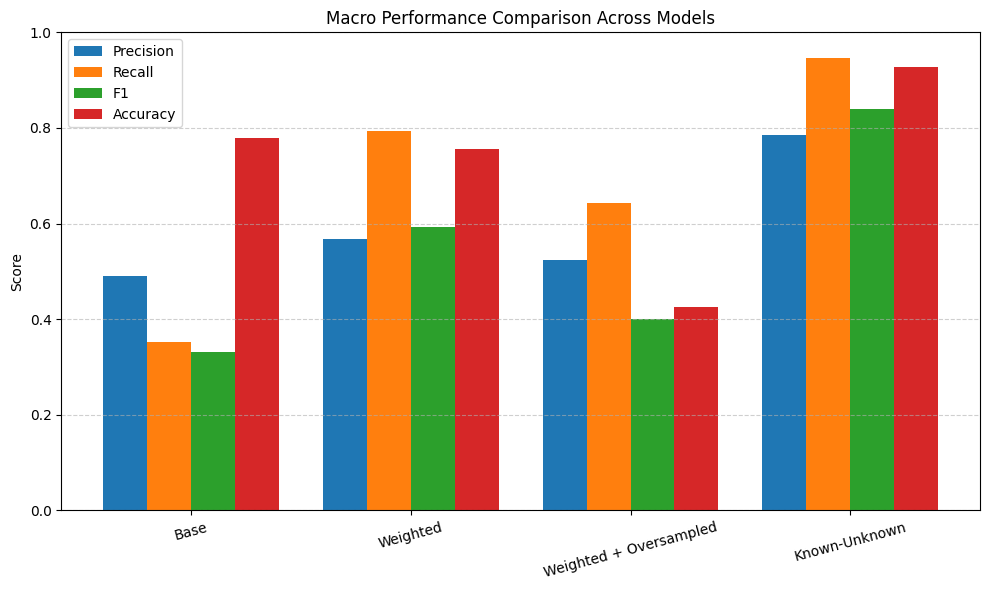

In [52]:
import matplotlib.pyplot as plt
import numpy as np

macro_metrics = ["precision", "recall", "f1", "accuracy"]
models = list(metrics_data.keys())

# Create grouped bar plot
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(10,6))

for i, metric in enumerate(macro_metrics):
    values = [metrics_data[m][metric] for m in models]
    plt.bar(x + i*width - width*1.5, values, width, label=metric.capitalize())

plt.xticks(x, models, rotation=15)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Macro Performance Comparison Across Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

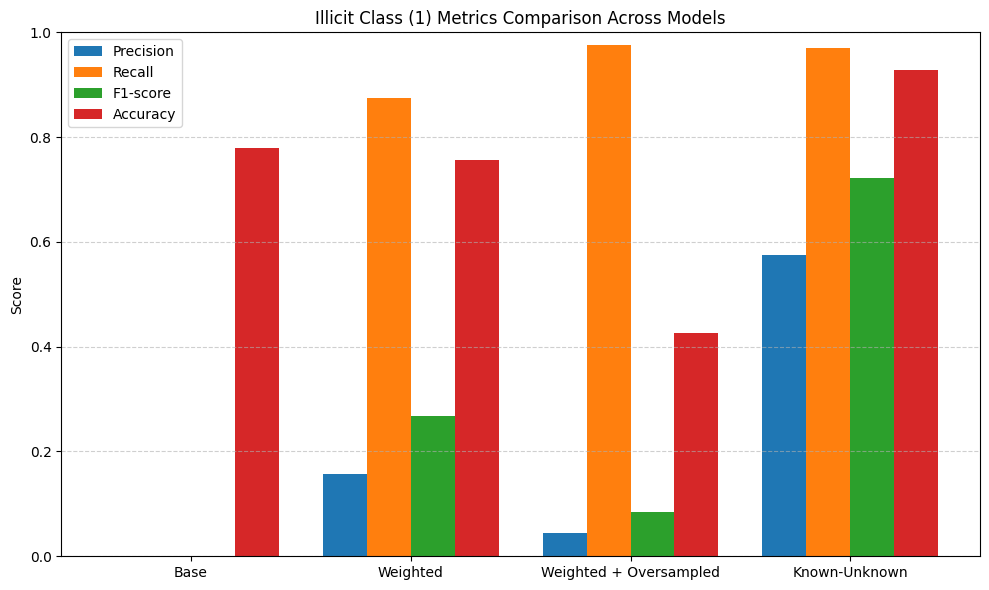

In [58]:
models = list(metrics_data.keys())
metrics_to_plot = ["precision", "recall", "f1-score", "accuracy"]

# Collect values for class 1 + overall accuracy
values_dict = {metric: [] for metric in metrics_to_plot}

for model in models:
    report = metrics_data[model]["per_class_report"]
    # Class 1 metrics
    for metric in ["precision", "recall", "f1-score"]:
        values_dict[metric].append(report.get("1", {}).get(metric, 0.0))
    # Overall accuracy
    values_dict["accuracy"].append(metrics_data[model].get("accuracy", 0.0))

# Plotting
x = np.arange(len(models))
bar_width = 0.2
plt.figure(figsize=(10,6))

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*bar_width - bar_width*1.5, values_dict[metric], width=bar_width, label=metric.capitalize())

plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Illicit Class (1) Metrics Comparison Across Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

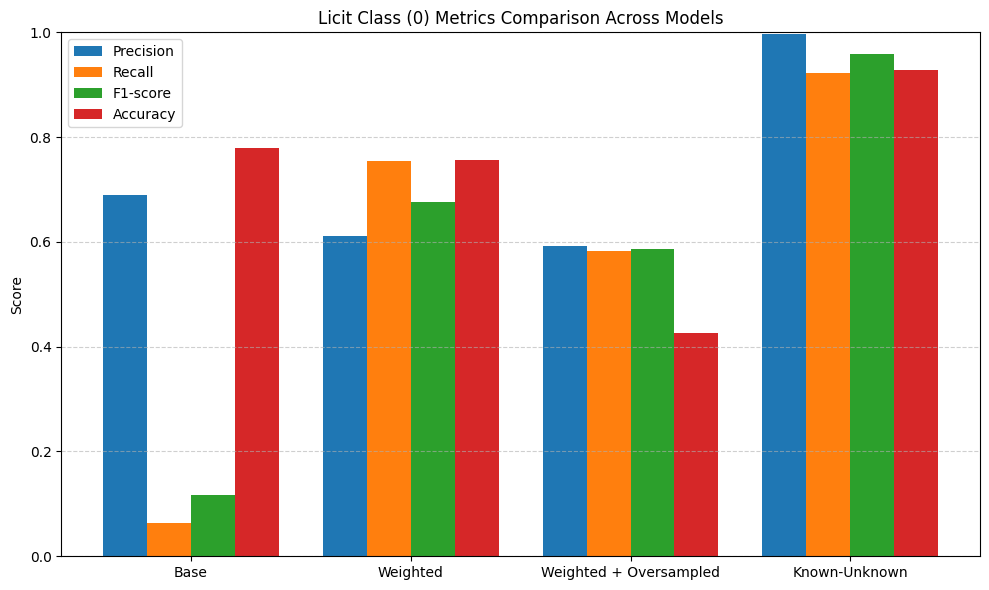

In [59]:
models = list(metrics_data.keys())
metrics_to_plot = ["precision", "recall", "f1-score", "accuracy"]

# Collect values for class 1 + overall accuracy
values_dict = {metric: [] for metric in metrics_to_plot}

for model in models:
    report = metrics_data[model]["per_class_report"]
    # Class 1 metrics
    for metric in ["precision", "recall", "f1-score"]:
        values_dict[metric].append(report.get("0", {}).get(metric, 0.0))
    # Overall accuracy
    values_dict["accuracy"].append(metrics_data[model].get("accuracy", 0.0))

# Plotting
x = np.arange(len(models))
bar_width = 0.2
plt.figure(figsize=(10,6))

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*bar_width - bar_width*1.5, values_dict[metric], width=bar_width, label=metric.capitalize())

plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Licit Class (0) Metrics Comparison Across Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()